In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import pandas as pd
from datetime import datetime
import time

# # Assuming evaluate is defined elsewhere
# # from your_module import evaluate
import torch.optim as optim

from tqdm.auto import tqdm
from collections.abc import Iterable
import perceval as pcvl
from boson_sampler import BosonSampler
import numpy as np
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from utils import MNIST_partial, accuracy, plot_training_metrics

# from model import MnistModel, evaluate
import torch.nn as nn
import torch.nn.functional as F

# simulator = pcvl.Simulator(pcvl.NaiveBackend())
from scipy.optimize import minimize


from torchmps import MPS

import warnings

warnings.filterwarnings("ignore")

In [2]:
# device = torch.device("cpu")
device = torch.device("cuda:0")

Boson sampler defined with number of parameters = 108, and embedding size = 126


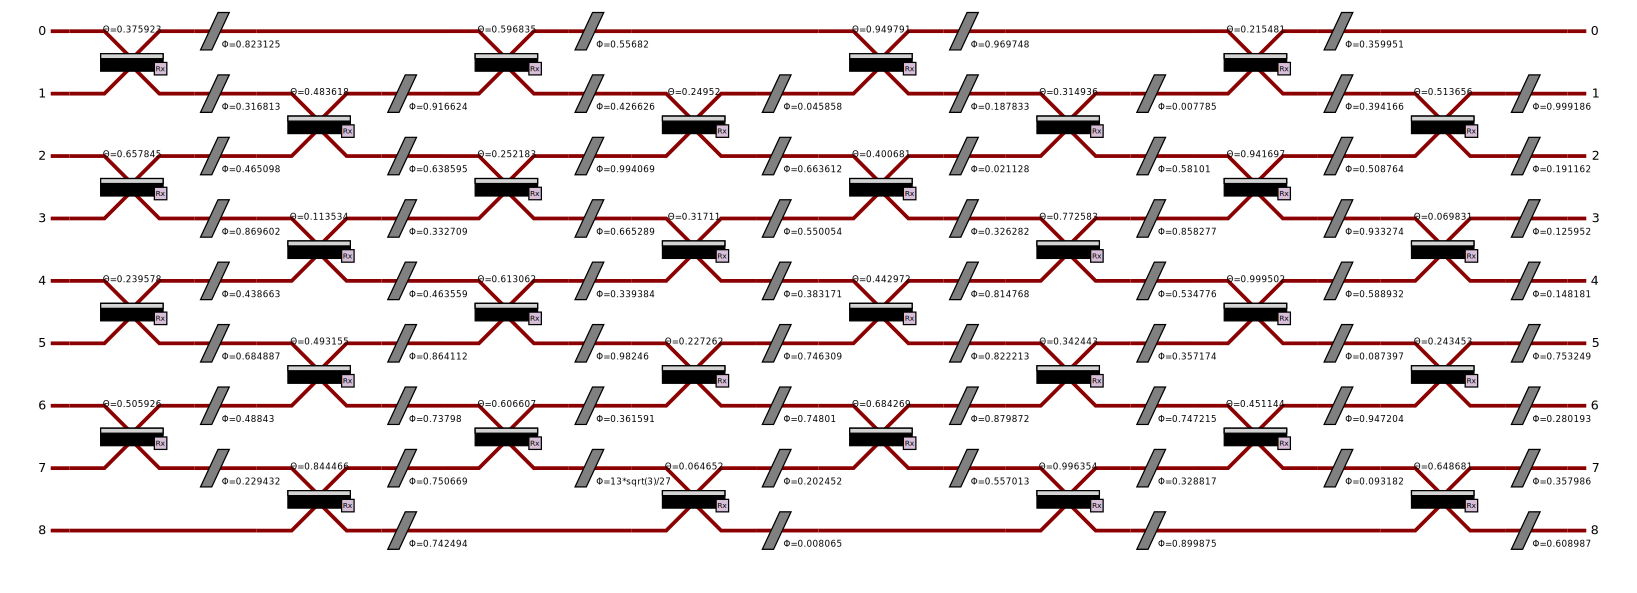

In [3]:
#### START SCALEWAY SESSION ####
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#### BOSON SAMPLER DEFINITION ####

bs_1 = BosonSampler(m=9, n=4, session=session)
print(
    f"Boson sampler defined with number of parameters = {bs_1.nb_parameters}, and embedding size = {bs_1.embedding_size}"
)
# to display it
pcvl.pdisplay(bs_1.create_circuit())

Boson sampler defined with number of parameters = 84, and embedding size = 70


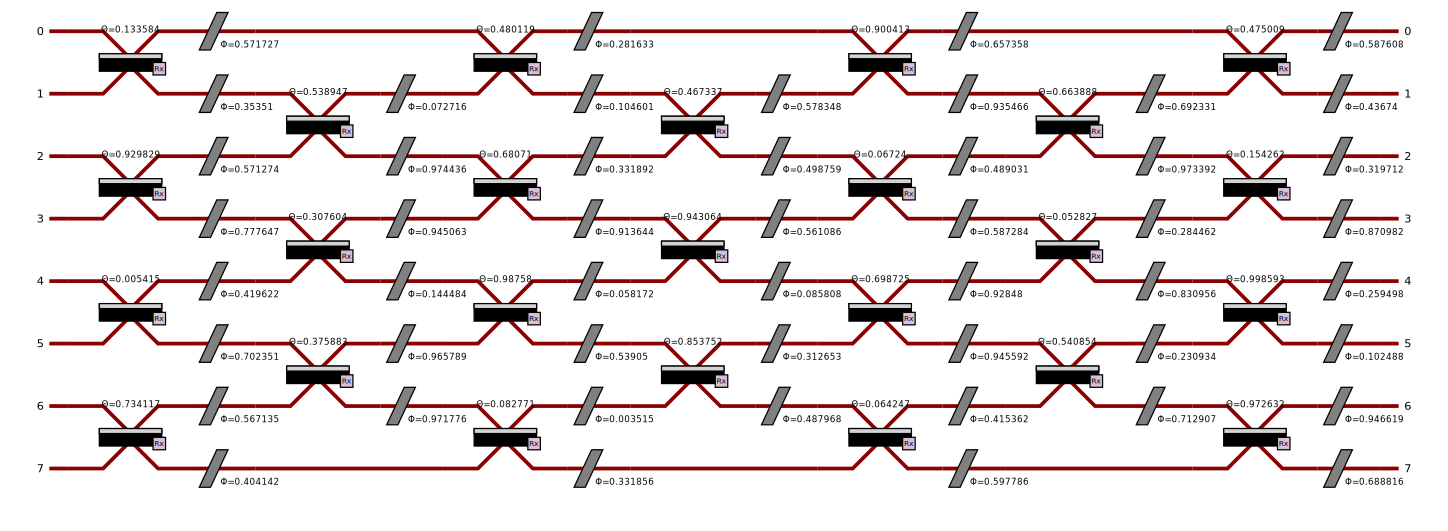

In [4]:
bs_2 = BosonSampler(m=8, n=4, session=session)
print(
    f"Boson sampler defined with number of parameters = {bs_2.nb_parameters}, and embedding size = {bs_2.embedding_size}"
)
# to display it
pcvl.pdisplay(bs_2.create_circuit())

In [5]:
126 * 70

8820

In [6]:
# random_para_tensor = torch.randn(84)
# res = bs_2.run(
#     parameters=random_para_tensor,
#     samples=100000
# )

# trans_res = bs_2.translate_results(res = res)
# print(trans_res)

In [7]:
# print(torch.mean(trans_res))

# trans_res = trans_res/torch.mean(trans_res)

# print(torch.mean(trans_res))


In [8]:
# count = 0
# for i in trans_res:
#     if i != 0:
#         count += 1
#     # print(i)
# print("non zero counts:", count)

In [9]:
# print(len(trans_res))

In [10]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        #     super(CNNModel, self).__init__()
        #     self.conv1 = nn.Conv2d(1, 4, kernel_size=4)
        #     self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #     self.conv2 = nn.Conv2d(4, 4, kernel_size=4)
        #     self.fc1 = nn.Linear(4*4*4, 20)
        #     self.fc2 = nn.Linear(20, 10)

        # def forward(self, x):
        #     x = self.pool(self.conv1(x))
        #     x = self.pool(self.conv2(x))
        #     x = x.view(x.size(0), -1) # [N, 32 * 8 * 8]
        #     x = self.fc1(x)
        #     x = self.fc2(x)
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 12, kernel_size=5)
        self.fc1 = nn.Linear(12 * 4 * 4, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.view(x.size(0), -1)  # [N, 32 * 8 * 8]
        x = self.fc1(x)
        x = self.fc2(x)
        return x


# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial(split="train")
val_dataset = MNIST_partial(split="val")

# definition of the dataloader, to process the data in the model
# here, we need a batch size of 1 to use the boson sampler
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [11]:
learning_rate = 1e-3
num_epochs = 1


# Instantiate the model and loss function
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_classical_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("# of parameters in classical CNN model: ", num_classical_parameter)

# of parameters in classical CNN model:  6690


In [12]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}"
            )

In [13]:
# Testing loop
model.eval()
correct = 0
total = 0
loss_test_list = []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

Accuracy on the test set: 79.00%


In [14]:
### required qubits estimation ##############
# NN weights

numpy_weights = {}
nw_list = []
nw_list_normal = []
for name, param in model.state_dict().items():
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

#############################################

# of NN parameters:  6690
Required qubit number:  13


In [15]:
# len(np.zeros(126)[63:])

In [16]:
### Some tool function definition ###########
def probs_to_weights(probs_):
    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for name, param in CNNModel().state_dict().items():
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        new_state_dict[name] = chunk
        data_iterator = data_iterator[num_elements:]

    return new_state_dict


def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states


#############################################

### Main Learning-wise Hybridization model ##


class PhotonicQuantumTrain(nn.Module):
    # class MappingModel(nn.Module):
    #     def __init__(self, input_size, hidden_sizes, output_size):
    #         super().__init__()
    #         # Initialize layers: an input layer, multiple hidden layers, and an output layer
    #         self.input_layer = nn.Linear(input_size, hidden_sizes[0])
    #         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
    #         self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    #     def forward(self, X):
    #         # Ensure the input tensor is the same type as the weights
    #         X = X.type_as(self.input_layer.weight)

    #         # Input layer with ReLU activation
    #         X = self.input_layer(X)

    #         # Hidden layers with ReLU activation
    #         for hidden in self.hidden_layers:
    #             X = hidden(X)

    #         # Output layer with linear activation
    #         output = self.output_layer(X)
    #         # output = F.tanh(output)  # It's often better to use ReLU or similar; tanh is used here as it was in the original model.
    #         return output

    def __init__(self):
        """ """
        super().__init__()
        # self.MappingNetwork = self.MappingModel(n_qubit+1, [8], 1).to(device)
        self.MappingNetwork = MPS(input_dim=n_qubit + 1, output_dim=1, bond_dim=8)

        # self.MappingNetwork = self.ConvMappingModel()
        # self.QuantumNN = nn.parameter(135)

        # self.QLayer(q_depth).to(device)   #arch={"n_blocks": q_depth})

    def forward(self, x, qnn_parameters):
        """ """
        self.q_params_1 = qnn_parameters[
            :108
        ]  # nn.Parameter(q_delta * torch.randn(135)).to(device)
        self.q_params_2 = qnn_parameters[108:]
        device = x.device

        res_1 = bs_1.run(parameters=self.q_params_1, samples=100000)
        trans_res_1 = bs_1.translate_results(res=res_1)
        trans_res_1 = trans_res_1 / torch.mean(trans_res_1)
        probs_1 = trans_res_1.to(device)

        res_2 = bs_2.run(parameters=self.q_params_2, samples=100000)
        trans_res_2 = bs_2.translate_results(res=res_2)
        trans_res_2 = trans_res_2 / torch.mean(trans_res_2)
        probs_2 = trans_res_2.to(device)

        probs_ = torch.ger(probs_1, probs_2).flatten().reshape(126 * 70, 1)

        # probs_ = trans_res.to(device)
        probs_ = probs_[: len(nw_list_normal)]
        probs_ = probs_.reshape(len(nw_list_normal), 1)

        # Generate qubit states using PyTorch
        qubit_states_torch = generate_qubit_states_torch(n_qubit)[: len(nw_list_normal)]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(
            len(nw_list_normal), n_qubit + 1
        )

        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = (
            prob_val_post_processed - prob_val_post_processed.mean()
        )

        state_dict = probs_to_weights(prob_val_post_processed)

        ########

        dtype = torch.float32  # Ensure all tensors are of this type

        # Convolution layer 1 parameters
        conv1_weight = state_dict["conv1.weight"].to(device).type(dtype)
        conv1_bias = state_dict["conv1.bias"].to(device).type(dtype)

        # Convolution layer 2 parameters
        conv2_weight = state_dict["conv2.weight"].to(device).type(dtype)
        conv2_bias = state_dict["conv2.bias"].to(device).type(dtype)

        # Fully connected layer 1 parameters
        fc1_weight = state_dict["fc1.weight"].to(device).type(dtype)
        fc1_bias = state_dict["fc1.bias"].to(device).type(dtype)

        # Fully connected layer 2 parameters
        fc2_weight = state_dict["fc2.weight"].to(device).type(dtype)
        fc2_bias = state_dict["fc2.bias"].to(device).type(dtype)

        # Convolution 1
        x = F.conv2d(x, conv1_weight, conv1_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Convolution 2
        x = F.conv2d(x, conv2_weight, conv2_bias, stride=1)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected 1
        x = F.linear(x, fc1_weight, fc1_bias)

        # Fully connected 2
        x = F.linear(x, fc2_weight, fc2_bias)

        return x

In [17]:
### Training setting ########################
num_epochs = 5
step = 1e-3  # Learning rate
# batch_size = 64       # Number of samples for each training step
gamma_lr_scheduler = 0.1  # Learning rate reduction applied every 10 epochs.
q_delta = (
    2 * np.pi
)  # Phases are 2 pi periodic --> we get better expressivity by multiplying the values by 2 pi

# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

init_qnn_parameters = q_delta * np.random.rand(108 + 84)

qnn_parameters = init_qnn_parameters

# Instantiate the model, move it to GPU, and set up loss function and optimizer
qt_model = PhotonicQuantumTrain().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(qt_model.parameters(), lr=step)  # , weight_decay=1e-5, eps=1e-6)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose = True, factor = 0.5)  # 'min' because we're minimizing loss

# num_trainable_params_MM = sum(p.numel() for p in PhotonicQuantumTrain.MappingModel(n_qubit+1,  [20, 4], 1).parameters() if p.requires_grad)
# num_trainable_params_MM = sum(p.numel() for p in LewHybridNN.ConvMappingModel().parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in qt_model.parameters() if p.requires_grad)
print("# of trainable parameter in Mapping model: ", num_trainable_params)
print(
    "# of trainable parameter in QNN model: ", bs_1.nb_parameters + bs_2.nb_parameters
)
print(
    "# of trainable parameter in full model: ",
    num_trainable_params + bs_1.nb_parameters + bs_2.nb_parameters,
)

# of trainable parameter in Mapping model:  1984
# of trainable parameter in QNN model:  192
# of trainable parameter in full model:  2176


In [18]:
# # Get a single random batch
# train_iter = iter(train_loader)  # Create an iterator
# images, labels = next(train_iter)

# print(labels)

In [19]:
num_training_rounds = 200
batch_size_qnn = 1000
train_loader_qnn = DataLoader(train_dataset, batch_size_qnn, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

global images, labels

#############################################
### Training loop ###########################
#############################################

loss_list = []
loss_list_epoch = []
acc_list_epoch = []
for round_ in range(num_training_rounds):
    print("-----------------------")

    acc_list = []
    acc_best = 0
    for epoch in range(num_epochs):
        qt_model.train()
        train_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            correct = 0
            total = 0
            since_batch = time.time()

            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            # Forward pass
            outputs = qt_model(images, qnn_parameters=qnn_parameters)
            # print("output: ", outputs)
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Compute loss
            loss = criterion(outputs, labels)
            # log_loss = torch.log(loss + 1e-6)

            loss_list.append(loss.cpu().detach().numpy())
            acc = 100 * correct / total
            acc_list.append(acc)
            train_loss += loss.cpu().detach().numpy()

            # np.array(loss_list).dump("L1/3/loss_list.dat")
            # np.array(acc_list).dump("L1/3/acc_list.dat")
            if acc > acc_best:
                # torch.save(model, 'L1/3/tq_mm_acc_'+str(int(acc))+'_bsf')
                acc_best = acc
            # Backward pass and optimization
            loss.backward()

            optimizer.step()
            if (i + 1) % 20 == 0:
                print(
                    f"Training round [{round_ + 1}/{num_training_rounds}], Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}, accuracy:  {(acc):.2f}%"
                )

        train_loss /= len(train_loader)
        # scheduler.step(train_loss)

    #############################################

    num_batch_qnn = 1

    for batch_ in range(num_batch_qnn):
        # print(f"Training round [{round_+1}/{num_training_rounds}]")
        # print(f"Training round [{round_+1}/{num_training_rounds}], qnn batch {batch_ + 1}")
        global qnn_train_step
        qnn_train_step = 0

        # Get a single random batch
        train_iter = iter(train_loader_qnn)  # Create an iterator
        images, labels = next(train_iter)

        def qnn_minimize_loss(qnn_parameters_=None):
            global qnn_train_step
            global images, labels

            correct = 0
            total = 0

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = qt_model(images, qnn_parameters=qnn_parameters_)
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            loss = loss.cpu().detach().numpy()
            acc = 100 * correct / total
            loss_list.append(loss)

            qnn_train_step += 1
            if qnn_train_step % 100 == 0:
                # print("qnn_train_step :", qnn_train_step, ", loss :", loss, ", acc : ", acc)
                print(
                    f"Training round [{round_ + 1}/{num_training_rounds}], qnn_train_step: [{qnn_train_step}/{1000}], loss: {loss}, accuracy: {acc} %"
                )

            # print("qnn_parameters [:10] :", qnn_parameters_[:10])
            return loss

        # Nelder-Mead
        # COBYLA
        # SLSQP

        init_param = qnn_parameters
        result = minimize(
            qnn_minimize_loss,
            init_param,
            method="COBYLA",
            options={"maxiter": 1000, "adaptive": True},
        )

        qnn_parameters = result.x

    loss_list_epoch.append(loss)
    acc_list_epoch.append(acc)

-----------------------
Training round [1/200], Epoch [1/5], Step [20/47], Loss: 2.2763, batch time: 0.15, accuracy:  11.72%
Training round [1/200], Epoch [1/5], Step [40/47], Loss: 2.0169, batch time: 0.10, accuracy:  20.31%
Training round [1/200], Epoch [2/5], Step [20/47], Loss: 1.8650, batch time: 0.05, accuracy:  25.00%
Training round [1/200], Epoch [2/5], Step [40/47], Loss: 1.9022, batch time: 0.05, accuracy:  28.91%
Training round [1/200], Epoch [3/5], Step [20/47], Loss: 1.4758, batch time: 0.04, accuracy:  50.00%
Training round [1/200], Epoch [3/5], Step [40/47], Loss: 1.6684, batch time: 0.10, accuracy:  39.84%
Training round [1/200], Epoch [4/5], Step [20/47], Loss: 1.4145, batch time: 0.04, accuracy:  51.56%
Training round [1/200], Epoch [4/5], Step [40/47], Loss: 1.1993, batch time: 0.10, accuracy:  60.94%
Training round [1/200], Epoch [5/5], Step [20/47], Loss: 0.9904, batch time: 0.11, accuracy:  70.31%
Training round [1/200], Epoch [5/5], Step [40/47], Loss: 0.9655, ba

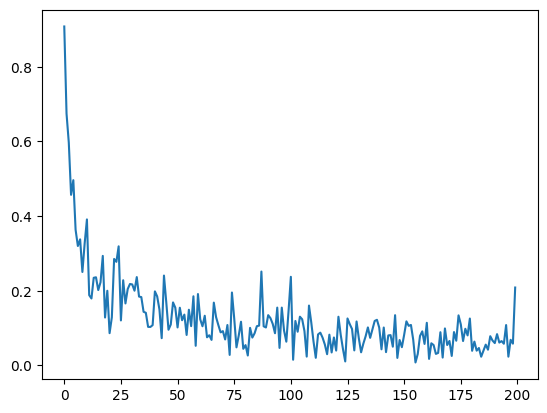

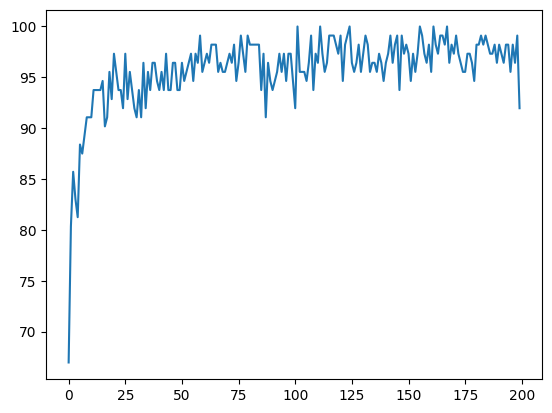

In [20]:
plt.plot([loss_i.cpu().detach() for loss_i in loss_list_epoch])
# plt.ylim(0.5, 2.5)
plt.show()


plt.plot(acc_list_epoch)
plt.show()

In [21]:
print([float(loss_i.cpu().detach()) for loss_i in loss_list_epoch])
print(acc_list_epoch)
# loss_list_epoch_ = [0.7851460576057434, 0.5637038350105286, 0.5420746207237244, 0.34920734167099, 0.38214829564094543, 0.19616656005382538, 0.390805184841156, 0.264143168926239, 0.19532908499240875, 0.1894717663526535, 0.22778603434562683, 0.13902343809604645, 0.19654493033885956, 0.18423175811767578, 0.19679059088230133, 0.1936047077178955, 0.1268329620361328, 0.16474607586860657, 0.11724834144115448, 0.20386622846126556, 0.04713213071227074, 0.0887191891670227, 0.2593144476413727, 0.2441752701997757, 0.048412106931209564, 0.12650121748447418, 0.1063842624425888, 0.11777462810277939, 0.21091096103191376, 0.17820271849632263, 0.15553784370422363, 0.18019436299800873, 0.09419118613004684, 0.0698174238204956, 0.1437043845653534, 0.0773288831114769, 0.18263664841651917, 0.15894773602485657, 0.1342155784368515, 0.07758193463087082, 0.0761612206697464, 0.10287091881036758, 0.08002384752035141, 0.06210542470216751, 0.07750963419675827, 0.29903700947761536, 0.13122527301311493, 0.08047519624233246, 0.09786634892225266, 0.03710215911269188, 0.07893260568380356, 0.20678620040416718, 0.13928858935832977, 0.07576180249452591, 0.13929857313632965, 0.049123551696538925, 0.06043660640716553, 0.04826120287179947, 0.1379205733537674, 0.10722009092569351, 0.10731107741594315, 0.13895076513290405, 0.14214272797107697, 0.04032004997134209, 0.031011288985610008, 0.12665481865406036, 0.019322287291288376, 0.03232140094041824, 0.1072009950876236, 0.07903237640857697, 0.2582106590270996, 0.057585638016462326, 0.07120381295681, 0.17948104441165924, 0.02759365737438202, 0.07343725860118866, 0.09247636049985886, 0.036617279052734375, 0.026302780956029892, 0.08696263283491135, 0.08046130836009979, 0.17218017578125, 0.11985071748495102, 0.1403731405735016, 0.08510155230760574, 0.07173147052526474, 0.04333014041185379, 0.10304577648639679, 0.08710026741027832, 0.08567804843187332, 0.14678451418876648, 0.061581600457429886, 0.09153060615062714, 0.07141439616680145, 0.06489415466785431, 0.027232874184846878, 0.07124467194080353, 0.1579284518957138, 0.030184103175997734, 0.05412973091006279, 0.06742018461227417, 0.08510424941778183, 0.15274827182292938, 0.08394268900156021, 0.06305151432752609, 0.056311435997486115, 0.05288488790392876, 0.05147498473525047, 0.0630447119474411, 0.029992956668138504, 0.12276951223611832, 0.11408579349517822, 0.2478996217250824, 0.09730955213308334, 0.09814775735139847, 0.15089812874794006, 0.031817249953746796, 0.03880956396460533, 0.034264300018548965, 0.10150768607854843, 0.058996137231588364, 0.07140914350748062, 0.0987752228975296, 0.024511173367500305, 0.0315927118062973, 0.08458546549081802, 0.05902286618947983, 0.12580014765262604, 0.07357534021139145, 0.05594825744628906, 0.12097673118114471, 0.05977540463209152, 0.042559172958135605, 0.03602229803800583, 0.10455860942602158, 0.10860250145196915, 0.05071258172392845, 0.05889898166060448, 0.06102382391691208, 0.07412650436162949, 0.10382433235645294, 0.07210692018270493, 0.04509314149618149, 0.1060018390417099, 0.059130582958459854, 0.07708600908517838, 0.056486643850803375, 0.0528167188167572, 0.029062164947390556, 0.10040052980184555, 0.04673455283045769, 0.05828046798706055, 0.07255307585000992, 0.04519138112664223, 0.08186684548854828, 0.04611990600824356, 0.08237038552761078, 0.054950959980487823, 0.08831409364938736, 0.06820104271173477, 0.038018275052309036, 0.12234993278980255, 0.08238237351179123, 0.040849048644304276, 0.0322626456618309, 0.03353416547179222, 0.05538661405444145, 0.11490869522094727, 0.13324418663978577, 0.02504158392548561, 0.10135437548160553, 0.06468857079744339, 0.1409846991300583, 0.04971366748213768, 0.03275028616189957, 0.03990314155817032, 0.026818962767720222, 0.09649360924959183, 0.030868304893374443, 0.07813842594623566, 0.02931353636085987, 0.040195100009441376, 0.08059387654066086, 0.060914237052202225, 0.08855114132165909, 0.07271069288253784, 0.09324382990598679, 0.04651874303817749, 0.08334646373987198, 0.0387013740837574, 0.12071596086025238, 0.08144911378622055, 0.09773600846529007, 0.058309342712163925, 0.11344309151172638, 0.05000309273600578, 0.051452379673719406, 0.07206863909959793, 0.04083022475242615, 0.03631418198347092]
# acc_list_epoch_ = [66.96428571428571, 83.92857142857143, 87.5, 91.96428571428571, 90.17857142857143, 94.64285714285714, 91.07142857142857, 93.75, 95.53571428571429, 94.64285714285714, 93.75, 95.53571428571429, 93.75, 93.75, 93.75, 94.64285714285714, 96.42857142857143, 95.53571428571429, 93.75, 91.07142857142857, 98.21428571428571, 96.42857142857143, 93.75, 93.75, 98.21428571428571, 98.21428571428571, 96.42857142857143, 96.42857142857143, 91.96428571428571, 93.75, 93.75, 93.75, 97.32142857142857, 97.32142857142857, 96.42857142857143, 97.32142857142857, 96.42857142857143, 94.64285714285714, 95.53571428571429, 96.42857142857143, 98.21428571428571, 97.32142857142857, 97.32142857142857, 99.10714285714286, 98.21428571428571, 91.07142857142857, 96.42857142857143, 97.32142857142857, 96.42857142857143, 98.21428571428571, 96.42857142857143, 92.85714285714286, 95.53571428571429, 98.21428571428571, 91.96428571428571, 98.21428571428571, 98.21428571428571, 98.21428571428571, 95.53571428571429, 95.53571428571429, 94.64285714285714, 98.21428571428571, 96.42857142857143, 98.21428571428571, 99.10714285714286, 97.32142857142857, 100.0, 99.10714285714286, 95.53571428571429, 96.42857142857143, 90.17857142857143, 99.10714285714286, 97.32142857142857, 91.96428571428571, 99.10714285714286, 96.42857142857143, 97.32142857142857, 100.0, 99.10714285714286, 98.21428571428571, 97.32142857142857, 93.75, 94.64285714285714, 96.42857142857143, 96.42857142857143, 96.42857142857143, 97.32142857142857, 94.64285714285714, 97.32142857142857, 96.42857142857143, 96.42857142857143, 97.32142857142857, 96.42857142857143, 97.32142857142857, 97.32142857142857, 99.10714285714286, 95.53571428571429, 95.53571428571429, 98.21428571428571, 98.21428571428571, 97.32142857142857, 96.42857142857143, 93.75, 95.53571428571429, 98.21428571428571, 98.21428571428571, 99.10714285714286, 98.21428571428571, 98.21428571428571, 99.10714285714286, 97.32142857142857, 96.42857142857143, 91.96428571428571, 95.53571428571429, 97.32142857142857, 94.64285714285714, 100.0, 99.10714285714286, 99.10714285714286, 96.42857142857143, 97.32142857142857, 98.21428571428571, 94.64285714285714, 100.0, 99.10714285714286, 98.21428571428571, 99.10714285714286, 97.32142857142857, 97.32142857142857, 98.21428571428571, 96.42857142857143, 97.32142857142857, 99.10714285714286, 97.32142857142857, 97.32142857142857, 94.64285714285714, 98.21428571428571, 97.32142857142857, 96.42857142857143, 96.42857142857143, 98.21428571428571, 97.32142857142857, 98.21428571428571, 96.42857142857143, 97.32142857142857, 97.32142857142857, 97.32142857142857, 97.32142857142857, 99.10714285714286, 97.32142857142857, 98.21428571428571, 97.32142857142857, 97.32142857142857, 97.32142857142857, 94.64285714285714, 97.32142857142857, 97.32142857142857, 98.21428571428571, 94.64285714285714, 97.32142857142857, 99.10714285714286, 94.64285714285714, 95.53571428571429, 98.21428571428571, 98.21428571428571, 99.10714285714286, 98.21428571428571, 95.53571428571429, 97.32142857142857, 99.10714285714286, 95.53571428571429, 97.32142857142857, 95.53571428571429, 98.21428571428571, 99.10714285714286, 98.21428571428571, 99.10714285714286, 97.32142857142857, 100.0, 96.42857142857143, 98.21428571428571, 98.21428571428571, 98.21428571428571, 98.21428571428571, 97.32142857142857, 98.21428571428571, 98.21428571428571, 98.21428571428571, 99.10714285714286, 98.21428571428571, 99.10714285714286, 96.42857142857143, 96.42857142857143, 97.32142857142857, 94.64285714285714, 99.10714285714286, 98.21428571428571, 95.53571428571429, 100.0, 99.10714285714286]

[0.9080109000205994, 0.6745071411132812, 0.5965717434883118, 0.4569703936576843, 0.4962361752986908, 0.3632756769657135, 0.31983333826065063, 0.33773085474967957, 0.2502496540546417, 0.3268689215183258, 0.3910798132419586, 0.1881592571735382, 0.17923879623413086, 0.23468224704265594, 0.23602499067783356, 0.20178388059139252, 0.22276410460472107, 0.2933639883995056, 0.12821371853351593, 0.1999405324459076, 0.08632693439722061, 0.12902003526687622, 0.2851587235927582, 0.2774178683757782, 0.31896069645881653, 0.12044165283441544, 0.22810661792755127, 0.1659553498029709, 0.20459838211536407, 0.2180968075990677, 0.21686771512031555, 0.20007765293121338, 0.23653586208820343, 0.18435977399349213, 0.18297278881072998, 0.14365573227405548, 0.14089739322662354, 0.10317806154489517, 0.10293370485305786, 0.10783382505178452, 0.19829177856445312, 0.18485097587108612, 0.1498844176530838, 0.07288859039545059, 0.2406650334596634, 0.1704312115907669, 0.0954568013548851, 0.10934330523014069, 0.168705627

In [22]:
# Testing train loop
qt_model.eval()
correct = 0
total = 0
loss_train_list = []
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = qt_model(images, qnn_parameters)
        loss_train = criterion(outputs, labels).cpu().detach().numpy()
        loss_train_list.append(loss_train)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")

# Testing loop
qt_model.eval()
correct = 0
total = 0
loss_test_list = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = qt_model(images, qnn_parameters)
        loss_test = criterion(outputs, labels).cpu().detach().numpy()
        loss_test_list.append(loss_test)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))

Accuracy on the train set: 96.75%
Loss on the train set: 0.09
Accuracy on the test set: 94.17%
Loss on the test set: 0.22
Generalization error: 0.1351644


In [23]:
# # Testing train loop
# model.eval()
# correct = 0
# total = 0
# loss_train_list = []
# with torch.no_grad():
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to GPU
#         outputs = model(images)
#         loss_train = criterion(outputs, labels).cpu().detach().numpy()
#         loss_train_list.append(loss_train)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")
# print(f"Loss on the train set: {np.mean(loss_train_list):.2f}")

# # Testing loop
# model.eval()
# correct = 0
# total = 0
# loss_test_list = []

# with torch.no_grad():
#     for images, labels in val_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to GPU
#         outputs = model(images)
#         loss_test = criterion(outputs, labels).cpu().detach().numpy()
#         loss_test_list.append(loss_test)

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")
# print(f"Loss on the test set: {np.mean(loss_test_list):.2f}")

# print("Generalization error:", np.mean(loss_test_list) - np.mean(loss_train_list))

In [24]:
# def fit(
#     epochs: int,
#     lr: float,
#     model: torch.nn.Module,
#     train_loader: DataLoader,
#     val_loader: DataLoader,
#     bs: BosonSampler,
#     opt_func=torch.optim.SGD,
#     save_csv: bool = True,
#     csv_path: str = "training_history"
# ):
#     """
#     Trains the model for a specified number of epochs, evaluates on validation data,
#     and optionally saves the training history to a CSV file with a timestamp.

#     Args:
#         epochs (int): Number of epochs to train.
#         lr (float): Learning rate.
#         model (torch.nn.Module): The neural network model to train.
#         train_loader (DataLoader): DataLoader for training data.
#         val_loader (DataLoader): DataLoader for validation data.
#         bs (BosonSampler): BosonSampler instance for embedding.
#         opt_func (torch.optim.Optimizer, optional): Optimizer constructor. Defaults to torch.optim.SGD.
#         save_csv (bool, optional): Whether to save the training history to a CSV file. Defaults to True.
#         csv_path (str, optional): Base path/name for the CSV file. A timestamp will be appended. Defaults to "training_history".

#     Returns:
#         dict: A dictionary containing training and validation metrics per epoch.
#     """
#     # Initialize optimizer
#     optimizer = opt_func(model.parameters(), lr=lr)
#     criterion = torch.nn.CrossEntropyLoss()

#     # Initialize history dictionary
#     history = {
#         'epoch': [],
#         'train_loss': [],
#         'train_acc': [],
#         'val_loss': [],
#         'val_acc': []
#     }

#     # Determine the device from the model
#     device = next(model.parameters()).device
#     print(f"Training on device: {device}")

#     # Create a progress bar for epochs
#     epoch_bar = tqdm(range(1, epochs + 1), desc="Training Progress", unit="epoch")

#     for epoch in epoch_bar:
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0
#         total_samples = 0

#         # Iterate over training data
#         for batch in train_loader:
#             if model.embedding_size:
#                 images, labels = batch
#                 # Move images and labels to the device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Generate embeddings and move them to the device
#                 embs = bs.embed(images, n_sample=1000).to(device)

#                 # Forward pass with embeddings
#                 outputs = model(images, emb=embs.unsqueeze(0))
#             else:
#                 images, labels = batch
#                 # Move images and labels to the device
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 # Forward pass without embeddings
#                 outputs = model(images)

#             # Compute loss
#             loss = criterion(outputs, labels)

#             # Compute accuracy
#             _, preds = torch.max(outputs, 1)
#             acc = torch.sum(preds == labels.data).item()

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Accumulate loss and accuracy
#             running_loss += loss.item() * images.size(0)
#             running_corrects += acc
#             total_samples += images.size(0)

#         # Calculate epoch metrics
#         epoch_train_loss = running_loss / total_samples
#         epoch_train_acc = running_corrects / total_samples

#         # Validation phase
#         model.eval()
#         val_running_loss = 0.0
#         val_running_corrects = 0
#         val_total_samples = 0

#         with torch.no_grad():
#             for batch in val_loader:
#                 if model.embedding_size:
#                     images, labels = batch
#                     # Move images and labels to the device
#                     images = images.to(device)
#                     labels = labels.to(device)

#                     # Generate embeddings and move them to the device
#                     embs = bs.embed(images, n_sample=1000).to(device)

#                     # Forward pass with embeddings
#                     outputs = model(images, emb=embs.unsqueeze(0))
#                 else:
#                     images, labels = batch
#                     # Move images and labels to the device
#                     images = images.to(device)
#                     labels = labels.to(device)

#                     # Forward pass without embeddings
#                     outputs = model(images)

#                 # Compute loss
#                 loss = criterion(outputs, labels)

#                 # Compute accuracy
#                 _, preds = torch.max(outputs, 1)
#                 acc = torch.sum(preds == labels.data).item()

#                 # Accumulate loss and accuracy
#                 val_running_loss += loss.item() * images.size(0)
#                 val_running_corrects += acc
#                 val_total_samples += images.size(0)

#         # Calculate validation metrics
#         epoch_val_loss = val_running_loss / val_total_samples
#         epoch_val_acc = val_running_corrects / val_total_samples

#         # Update history
#         history['epoch'].append(epoch)
#         history['train_loss'].append(epoch_train_loss)
#         history['train_acc'].append(epoch_train_acc)
#         history['val_loss'].append(epoch_val_loss)
#         history['val_acc'].append(epoch_val_acc)

#         # Update the progress bar description
#         epoch_bar.set_postfix({
#             'Train Loss': f"{epoch_train_loss:.4f}",
#             'Train Acc': f"{epoch_train_acc:.4f}",
#             'Val Loss': f"{epoch_val_loss:.4f}",
#             'Val Acc': f"{epoch_val_acc:.4f}"
#         })

#     # Save history to CSV with timestamp
#     if save_csv:
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         csv_filename = f"{csv_path}_{timestamp}.csv"
#         history_df = pd.DataFrame(history)
#         history_df.to_csv(csv_filename, index=False)
#         print(f"\nTraining history saved to '{csv_filename}'.")

#     return history